![](https://i.imgur.com/eBRPvWB.png)

# Practical PyTorch: Generating Shakespeare with a Character-Level RNN

[In the RNN classification tutorial](https://github.com/spro/practical-pytorch/blob/master/char-rnn-classification/char-rnn-classification.ipynb) we used a RNN to classify text one character at a time. This time we'll generate text one character at a time.

```
> python generate.py -n 500

PAOLTREDN:
Let, yil exter shis owrach we so sain, fleas,
Be wast the shall deas, puty sonse my sheete.

BAUFIO:
Sirh carrow out with the knonuot my comest sifard queences
O all a man unterd.

PROMENSJO:
Ay, I to Heron, I sack, againous; bepear, Butch,
An as shalp will of that seal think.

NUKINUS:
And house it to thee word off hee:
And thou charrota the son hange of that shall denthand
For the say hor you are of I folles muth me?
```

This one might make you question the series title &mdash; "is that really practical?" However, these sorts of generative models form the basis of machine translation, image captioning, question answering and more. See the [Sequence to Sequence Translation tutorial](https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/seq2seq-translation.ipynb) for more on that topic.

# Recommended Reading

I assume you have at least installed PyTorch, know Python, and understand Tensors:

* http://pytorch.org/ For installation instructions
* [Deep Learning with PyTorch: A 60-minute Blitz](https://github.com/pytorch/tutorials/blob/master/Deep%20Learning%20with%20PyTorch.ipynb) to get started with PyTorch in general
* [jcjohnson's PyTorch examples](https://github.com/jcjohnson/pytorch-examples) for an in depth overview
* [Introduction to PyTorch for former Torchies](https://github.com/pytorch/tutorials/blob/master/Introduction%20to%20PyTorch%20for%20former%20Torchies.ipynb) if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

* [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) shows a bunch of real life examples
* [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) is about LSTMs specifically but also informative about RNNs in general

Also see these related tutorials from the series:

* [Classifying Names with a Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/char-rnn-classification/char-rnn-classification.ipynb) uses an RNN for classification
* [Generating Names with a Conditional Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/conditional-char-rnn/conditional-char-rnn.ipynb) builds on this model to add a category as input

# setup

In [35]:
!pwd

/Users/wcz/Google Drive/fastai_seminars.gt/rnn_generator_sylables


In [226]:
from pathlib import Path
dataset_path = Path('data/rnn_generator'); dataset_path
tmp_path = dataset_path / 'tmp/'
!mkdir -p $tmp_path

In [227]:
dataset_path

PosixPath('data/rnn_generator')

In [228]:
ls -lah $dataset_path/

total 1280
drwxr-xr-x  5 wcz  staff   160B Apr 30 13:56 ./
drwxr-xr-x  4 wcz  staff   128B Apr 30 13:27 ../
-rw-r--r--  1 wcz  staff   362K Apr 30 16:23 pan_tadeusz.syl1.txt
-rw-rw-rw-@ 1 wcz  staff   218K Apr 23 19:58 pan_tadeusz.txt
drwxr-xr-x  2 wcz  staff    64B Apr 30 13:27 tmp/


# vm monitoring

In [229]:
import os
import psutil

def print_memsize():
  process = psutil.Process(os.getpid())
  print(f'{process.memory_info().rss / 1024**3:.5} GB')

In [230]:
print_memsize()

0.14095 GB


In [231]:
!uptime

16:44  up 12 days,  6:56, 5 users, load averages: 1.92 1.93 1.94


# GPU

In [232]:
import torch

USE_GPU = torch.cuda.is_available(); 
# USE_GPU = False; 

print(f'USE_GPU={USE_GPU}')

def to_gpu(x, *args, **kwargs):
    return x.cuda(*args, **kwargs) if USE_GPU else x

USE_GPU=False


# Prepare data

The file we are using is a plain text file. We turn any potential unicode characters into plain ASCII by using the `unidecode` package (which you can install via `pip` or `conda`).

In [234]:
# import unidecode
import string
import random
import re

In [235]:
fn_corpus_char = dataset_path/'pan_tadeusz.txt'
fn_corpus_syl = dataset_path/'pan_tadeusz.syl1.txt'

fn_corpus_char = dataset_path/'pan_tadeusz.txt'
fn_corpus_syl = dataset_path/'pan_tadeusz.syl1.txt'

# taken from fastai/text.py
import re, string
# remove +,- chars from punctuation set to keep sylables e.g.'--PO++' intact
punctuation=re.sub('[\+-]', '', string.punctuation)
re_tok = re.compile(f'([{punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

corpus_syl_tok = tokenize(corpus_syl); len(corpus_syl_tok), corpus_syl_tok[:8]

all_tokens = sorted(list(set(corpus_syl_tok)))
n_tokens = len(all_tokens); print(n_tokens, all_tokens[:150])

5776 ['!', '"', '%', "'", '(', ')', ',', '--', '--CIA', '--DAR++', '--GA', '--GI', '--KA', '--LO++', '--MA++', '--MEK', '--MIZ++', '--NIA', '--PO++', '--RWSZA', '--S++', '--STWO', '--TA', '--TY++', '--WY', '--a++', '--aczéj', '--ał', '--b++', '--ba', '--ba++', '--bach', '--baj++', '--bak', '--ban', '--ban++', '--bar++', '--barz', '--baw', '--baw++', '--bał', '--baż', '--bcem', '--be++', '--bek', '--bel', '--bel++', '--belg', '--bem', '--ber++', '--bez++', '--beł', '--bi', '--bi++', '--bia', '--bia++', '--biad', '--biar++', '--biać', '--biał', '--bic', '--bie', '--bie++', '--biec', '--biedz', '--bieg++', '--biegł', '--biem', '--bier++', '--biet', '--biet++', '--bieć', '--bień++', '--bij++', '--bik', '--bim', '--bin', '--bin++', '--bio', '--bio++', '--bior', '--bios', '--bis++', '--bisz', '--bit++', '--biu', '--biw++', '--bié++', '--biór', '--biów', '--bią', '--bią++', '--biąc', '--bić', '--bię', '--bił', '--bił++', '--bla++', '--blad++', '--bled++', '--bli++', '--blis++', '--bliż++', '-

In [236]:
# map to old variable names
file = corpus_syl_tok
file_len = len(file)
all_characters = all_tokens
n_characters = n_tokens

To make inputs out of this big string of data, we will be splitting it into chunks.

In [242]:
chunk_len = 100

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

# print(random_chunk())

In [349]:
def syl2str(a_list, delim='/'): return ' '.join(a_list).replace('++ --', delim)
print(syl2str(random_chunk()))

--cu gdzie sta/ła , tyl/ko po/rzu/co/ny Ko/szyk ma/ły z ro/ki/ty , den/kiem wy/wró/co/ny . Po/gu/biw/szy o/wo/ce na li/ściach za/wi/sał , I wśród fa/li zie/lonéj je/sz/cze się ko/ły/sał . Po chwi/li wszę/dzie by/ło sa/mo/tnie i głu/cho ; Hra/bia o/czy w dom u/tkwił i na/tę/żył u/cho , Za/wsze du/mał , a strzel/cy za/wsze nie/ru/cho/mie Za nim sta/li . -- Aż w ci/chym i sa/mo/tnym do/mie Wszczął się na/przód szmer , potém gwar i krzyk we/so/ły , Jak w ulu pu/stym kie/dy weń wia/ta/ją pszczo/ły : Był to znak że wra/ca/li go/ście s po/lo/wa/nia , I krzą/ta/ła się służ/ba o/ko/ło śnia/da/nia . Ja/koż po wszy/s/t/kich iz/bach pa/no/wał ruch wiel/ki , Roz/no/szo/no po/tra/wy , sztu/czce i bu/tel/ki ; Mę/sz/czyz/ni tak jak we/szli , w swych zie/lo/nych stro/jach , S ta/le/rza/mi , s szklan/ka/mi , cho/dząc po po/ko/jach , Jed/li , pi/li , lub wspar/ci na o/kien u/sza/kach , Ro/spra/wia/li o flin/tach , char/tach i sza/ra/kach ; Pod/ko/mor/stwo i Sę/dzia przy sto/le ; a w kąt/ku Pan/ny szep/ta

# Build the Model

This model will take as input the character for step $t_{-1}$ and is expected to output the next character $t$. There are three layers - one linear layer that encodes the input character into an internal state, one GRU layer (which may itself have multiple layers) that operates on that internal state and a hidden state, and a decoder layer that outputs the probability distribution.

In [238]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(to_gpu(torch.zeros(self.n_layers, 1, self.hidden_size)))

# Inputs and Targets

Each chunk will be turned into a tensor, specifically a `LongTensor` (used for integer values), by looping through the characters of the string and looking up the index of each character in `all_characters`.

In [261]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(to_gpu(tensor))

# print(char_tensor('ala ma kota'))

In [262]:
a_token_list = corpus_syl_tok[20:30]; print(a_token_list)
print(char_tensor(a_token_list))

['--ka++', '--nie', 'się', 'pié++', '--rwsze', 'w', 'po++', '--koi++', '--ku', ',']
Variable containing:
  948
 1379
 4856
 4619
 1641
 5218
 4643
 1016
 1062
    6
[torch.LongTensor of size 10]



Finally we can assemble a pair of input and target tensors for training, from a random chunk. The input will be all characters *up to the last*, and the target will be all characters *from the first*. So if our chunk is "abc" the input will correspond to "ab" while the target is "bc".

In [245]:
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

# Evaluating

To evaluate the network we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation we pass a priming string to start building up the hidden state, from which we then generate one character at a time.

In [472]:
# Turn string into list of longs
# def char_tensor(string):
# #     print(f'char_tensor({string})')
#     tensor = torch.zeros(len(string)).long()
#     for c in range(len(string)):
# #         print(c)
#         tensor[c] = all_characters.index(string[c])
#     return Variable(to_gpu(tensor))

# def evaluate(prime_str='A', predict_len=100, temperature=0.8):
def evaluate(prime_str=[all_tokens[1]], predict_len=100, temperature=0.8):
#     print(f'prime_str={prime_str}')
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
#     predicted = prime_str
    predicted = list(prime_str)  # need a copy of the list

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
#         print(f'predicted_char = {predicted_char}')
#         predicted += predicted_char
        predicted.append(predicted_char)
#         print(f'predicted = {predicted}')
        inp = char_tensor([predicted_char])
#         inp = char_tensor(predicted_char)

#     print(f'predicted = {predicted}')
    return predicted

In [310]:
ac = all_characters
# prime_str = [ac[10], ac[20], ac[30]]; 
prime_str = [ac[10], ac[20], ac[30]]; 
prime_str = corpus_syl_tok[13:18]
print(syl2str(prime_str))
print(syl2str(evaluate(prime_str, 20, temperature=0.8)))

Po/wrot pa/ni/cza
Po/wrot pa/ni/cza . wy/cią++ już drze/szym , któ/ląc sta/nął , Do/ląc czar++ , A nad++ pad++ czy++


# Training

A helper to print the amount of time passed:

In [247]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

The main training function

In [248]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c])

    loss.backward()
    decoder_optimizer.step()

    return loss.data[0] / chunk_len

Then we define the training parameters, instantiate the model, and start training:

In [396]:
import visdom
import numpy as np

vis = visdom.Visdom()

def vis_update_line_chart(vis, name, x, y, first_step):
    vis.line(Y=np.array([y]), X=np.array([x]),
             win=name, opts=dict(title=name),
             update=None if first_step else 'append')

def vis_update_text_win(vis, name, text):
    vis.text(text, win=name, opts=dict(title=name), append=False)

In [446]:
# print(e_str)

class X(str):
    def rpl(self, p, c='lightgray'):
        return X(self.replace(p, f'<font color="{c}">{p}</font>'))

# def rpl(s, p): return s.replace(p, f'<font color="gray">{p}</font>')
out = X(e_str).rpl('/').rpl('--', c='red').rpl('++', c='blue')
print(out)
# e_str = e_str.replace('--', '<font color="gray">--</font>').replace('++', '<font color="lightgray">++</font>')

Po<font color="lightgray">/</font>wrot pa<font color="lightgray">/</font>ni<font color="lightgray">/</font>cza Re<font color="lightgray">/</font>nych , I <font color="red">--</font>ma<font color="blue">++</font> Szla<font color="lightgray">/</font>i<font color="blue">++</font> po<font color="blue">++</font> gry<font color="blue">++</font> złotém w i <font color="red">--</font>strze<font color="lightgray">/</font>cie<font color="lightgray">/</font>żyw<font color="lightgray">/</font>zja<font color="blue">++</font> na <font color="red">--</font>dzie<font color="lightgray">/</font>de<font color="blue">++</font> się Bir<font color="blue">++</font> s na <font color="red">--</font>rze , że<font color="blue">++</font> pań<font color="blue">++</font> , <font color="red">--</font>ni , ob<font color="lightgray">/</font>ni od<font color="lightgray">/</font>ga<font color="lightgray">/</font>chta do<font color="blue">++</font> i <font color="red">--</font>na Zo<font color="lightgray">/</font>cy i <f

In [463]:
print(e_str)
cc = len(e_syl); print(cc)
# print(e_syl)
def bad_words(e_syl): e_str = syl2str(e_syl); return (e_str.count('++') + e_str.count('--')) / len(e_syl)
print(bad_words(e_syl))

Po/wrot pa/ni/cza --li w wszy++ ma --ciętéj --me/sz++ we++ , I --czy++ w --ki , --ką , Go++ o++ u/cią/szyz/my e/ła++ ? i i --mkiem --łem raz łu/nia , lecz --ta/ły , , do DRU++ , --gał się --my --sta/da/gi Do++ , --lec++ po/ły , s --lar++ chwa++ i ran/dża/ło --dzić --nik --li++ mę++ czy++ się --ruj Do/gaić , Do++ naj++ , u++ zna++ , I , niż --czął --znać plan --czył się , --le/ma : --rwa/da --ne , I --li sto/wią++ ob++ , s za
105
0.4380952380952381


In [481]:
# USE_GPU = True
n_epochs = 2000   # 2000
print_every = 100 # 100
plot_every = 100
hidden_size = 100 # 100
n_layers = 1 # 1
lr = 0.005

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
if USE_GPU:
  decoder.cuda()
print(decoder, flush=True)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
if USE_GPU:
  criterion.cuda()

start = time.time()
all_losses = []
loss_avg = 0
all_bw = []
bw_avg = 0

from tqdm import tqdm

iterable = range(1, n_epochs + 1)
tqdm_ = tqdm(iterable, '', leave=False, dynamic_ncols=True)
first_step = True

for epoch in tqdm_:
    loss = train(*random_training_set())       
    loss_avg += loss

    # current loss chart
    vis_update_line_chart(vis, 'loss', epoch, loss, epoch == 1)
    
    # progress_bar
    tqdm_.set_postfix({'loss': loss})
    text = f'&nbsp;<font color="red">{tqdm_}</font>'
    vis.text(text, win='progress_bar', opts=dict(title='progress_bar'))#, append=False)

    # bad words
    bw = bad_words(evaluate(prime_str, 100))
    bw_avg += bw

    # current bad words chart
    vis_update_line_chart(vis, 'bad_words', epoch, bw, epoch == 1)
    
    if epoch % print_every == 0:
#         prime_str = 'Wh'
        prime_str = corpus_syl_tok[13:18]
        e_syl = evaluate(prime_str, 100)
        e_str = syl2str(e_syl)
#         bw = bad_words(e_syl)
        stats_str = '\n[%s (%d %d%%) loss=%.4f bw=%.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss, bw)
        print(stats_str)
#         e_str = e_str.replace('--', '<font color="gray">--</font>').replace('++', '<font color="lightgray">++</font>')
        e_html = X(e_str).rpl('/').rpl('--', c='red').rpl('++', c='red')
        print(e_str, '\n', flush=True)
        text = f'<b>{stats_str}</b><br />{e_html}'
        vis.text(text, win='evaluation', opts=dict(title='evaluation'))#, append=False)

    if epoch % plot_every == 0:
        # loss_avg chart
        vis_update_line_chart(vis, 'loss_avg', epoch, loss_avg / plot_every, first_step)
        # bad_words_avg chart
#         e_syl = evaluate(prime_str, 1000)
#         bw = bad_words(e_syl)
        vis_update_line_chart(vis, 'bad_words_avg', epoch, bw_avg / plot_every, first_step)
        all_bw.append(bw)
        bw_avg = 0
        
        first_step = False
        
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0
        

RNN(
  (encoder): Embedding(5776, 100)
  (gru): GRU(100, 100)
  (decoder): Linear(in_features=100, out_features=5776, bias=True)
)


  5%|▍         | 99/2000 [01:40<32:09,  1.01s/it, loss=6.84]


 40s (100 5%) loss=6.8424 bw=0.2000]
Po/wrot pa/ni/cza , ja/ko --mał , drżą/cie ; ró/do++ nad po/wie/lo/wa/zy , --mę++ nie++ pię/li/cy --rę , lub za++ złość w wrzas++ gło++ so/wy i księ++ w strza++ wo++ , strze++ sie++ po/wie/bia++ , mak --cie , że dwóch --tem , źre/co/sz/tem , śmierć --do++ , --bra++ I i --da --si s -- Z --go --je , A krzy++ rze/wał na/kształt --to/wy ; Pod/wa++ ja/ko prze/ko/gdzie się , I --ste --łu , W --rzy++ szpieg , mil/li/sz/go++ 



 10%|▉         | 199/2000 [03:23<30:45,  1.02s/it, loss=5.99]


 24s (200 10%) loss=5.9889 bw=0.1238]
Po/wrot pa/ni/cza ; Po jak gło/jąc po/grą++ , dwa Te/li/me/na ; sa/li nie/da/da wy/wią/wą . sad --li/cy u/sta/nie , trzeź/ro/ków , Słu++ nie/na/mi da/w/ne ; Ger/wa/dzi Ten nie/dba/nia o/czy/kiem się przy/bli/ło/zi/ra/ny i pod/bie/mu ; Gdy za/je/nia i wnu/wie , I o/czu --stwem --dziéj ; --żu/lich tych , A w --ców hi++ , Sto/nar/my , O/ko/mo/li --ścić , i nikt spad++ 



 15%|█▍        | 299/2000 [05:17<30:05,  1.06s/it, loss=4.87]


 17s (300 15%) loss=4.8745 bw=0.0381]
Po/wrot pa/ni/cza , nie/spo/chyb/ta . Ale po/je/wo i ko/gut++ , Znak --len/łem -- U/nąw/szy , Za gó/ry , w pu/sz/ka , na/wet , jak sku/rą/ni/cę . Po/wo/ły ja/rzy/szy , wpad/ni , ro/spię/ka , dłu/go z oj/ni , ni Pan gnie/s/te/ki i ha/ła/szy , I wo/lę ; U/pie++ tu na bie/gu nie --cha/wał , I ciot/ka się go , nie++ kres/cho/my , i w u/stach 



 20%|█▉        | 399/2000 [07:05<28:27,  1.07s/it, loss=5.21]


 5s (400 20%) loss=5.2063 bw=0.0381]
Po/wrot pa/ni/cza , że nie/cier/pli/wa , raz się stem/pel przez roz/da/mi . -- Na/zy/tów ko/ło z la/tach pań/skie po/lo/wa/nie in/ter/es/mo/rzy , Wlaw/dzi i e/chem , O/pa/brał co nim u/cych , a na nich sto/łu , Wprzód się w cu/dzych J nim słoń/ca , Dzie++ flin/ka o/gro/ra/ją po/wia/dał . Grzę/li/wiec do/my , po/ło/jo/sza so/bie się ty/łu . On li/ca , Że Sta++ 



 25%|██▍       | 499/2000 [08:54<26:46,  1.07s/it, loss=4.16]


 54s (500 25%) loss=4.1570 bw=0.0286]
Po/wrot pa/ni/cza , Nikt z o/czu , czy na pa/sie ? -- czy pięk/ny , I prze/rwać , i po/rzu/ca/ła na ko/ło o/prócz się nie/by/ła ciem/ki , Zga/dnij++ rę/ce ? Ów --dzia/ne _ krąg/łe , Pa/nien/ła z roz/dar/ku . Tak to nie/bo za/żył Klu/cz/nik , pu/dy stał wszy/s/t/kim za/le/tę w ro/ga/łu/ło ! Gło/ski , Vul/na/ny , A rzę/dem się ro/dzi/no , , pra++ 



 30%|██▉       | 599/2000 [10:42<25:03,  1.07s/it, loss=4.58]


 42s (600 30%) loss=4.5840 bw=0.0190]
Po/wrot pa/ni/cza --cz/nik , Ale i wes/li/cmaj/ster szu/kać nam --jazd od/wra/sty ; I za nią Pan pod mo/że ? krzyk/nę/ła , As/ses/sor , Pan po/ra/dzał , Za/ba/wić i przy/ja/cie/le , I pod/ska++ nie/żył , A s po/ra/nek i przy/brał le/ża/wym , Potém rę/ce sie/bie roz/go/mo/rze/mu i go/ści , pra/wa , człek mąd/ry wa/run/le . Hra/bia u/sieść na bra/mę , S któ/re 



 35%|███▍      | 699/2000 [12:31<23:19,  1.08s/it, loss=2.92]


 32s (700 35%) loss=2.9199 bw=0.0286]
Po/wrot pa/ni/cza już do go/d/nie ; Tyl/ko znak --rę je/sz/cze , na/ra/żać , Bo zda/rać o/sza się , po li/sa za/py/ta , W bie/gu A/mal/tei , sa/mi mu/zy/ce się ciąg/le , s po/dmu/chem Ca/ły kwiat , o/gro/tym rzeź/ka/jąc na/dziei i lu/dzie ; Tyl/ko wi/dzia/na strzel/cy krę/ci się , prze/jrzy/rzy/ga/la na/ra/zów , Pier/w/szy raz w gwiaz/dy , na/tchnio/niec w 



 40%|███▉      | 799/2000 [14:26<21:41,  1.08s/it, loss=4.37]


 26s (800 40%) loss=4.3650 bw=0.0286]
Po/wrot pa/ni/cza , w kształt ser/cem u/jrzał co mu rzu/cił , w głos cio/ciu przy gra/ni/ca , Jak skrom++ przed pra/la/rzy/nę dol/nym gło/wę : Jak kot z od/głos dzię/ku żub/ła/mi , Jak kot z dwoj/dem , go/s/ną/nym da/je , na po/wró/cił źmi/ja , Dwoistém --le/wa wie/cze/rzy ; Tak Pod/ko/mo/rzy , Mil/czą/cy , dru/gie/mi je/sz/cze słu/la/li , Któ/ry już po/no mo/dem i zie++ 



 45%|████▍     | 899/2000 [16:19<19:59,  1.09s/it, loss=2.11]


 19s (900 45%) loss=2.1117 bw=0.0000]
Po/wrot pa/ni/cza blas/ku , i choć niż/ży u/ro/dzi ; więc wszys/cy , rześ/ki za/ję/ty , rześ/ki pro/stac/ni/ły cieś/ne ze słów iz/bie ich dziś , do w ro/gu , do/tąd wy/ro/bio/ry , ci --ła w bie/rze , bo tak był to są , by/ło krzy/ku , Je/d/ną no/gą » a więc na ro/gu ; go w pół o/łó/wek , sprzę/ty jéj wy/stą/pił pan/ny . -- A Pan Sę/dzia go bu++ 



 50%|████▉     | 999/2000 [18:09<18:12,  1.09s/it, loss=3.23]


 10s (1000 50%) loss=3.2283 bw=0.0286]
Po/wrot pa/ni/cza , już tuż przy siod/le , swa/wol/nie mó/wię roz/ma/wiał , Za/rą++ by/ło w po/le , jak śnieg pod/nios/ły mu od/pu/ściw/szy , Mi/ja/ły , I chcąc jak przy/cho/wych na swym pę/ka/mi po/dzię/ni , U/zbyt się , je/sz/cze dym szedł z gó/ry , na/zbyt ściś/wi/łem ; Czy to wszy/s/t/ko los zwykł rzu/ca/jąc w las dro/gą , Z ge/stów ćwi/wo/wa/ły w go/wa/nia 



 55%|█████▍    | 1099/2000 [19:59<16:23,  1.09s/it, loss=2.93]


 59s (1100 55%) loss=2.9268 bw=0.0476]
Po/wrot pa/ni/cza --pał prze/mo/cha : Je/ś/li znaj/dziesz wszy/s/t/kie ra/mio/tów ; wi/do/ka/nie , Cią/g/nął woź/nień/skim u/słu/gi , Wy/dep/tał li/cz/ne/mi , przy/sięg/li przez chciał po/pie/lił : Bo gło/wę , i tak ob/ras/ku , O/rzeł nie/ską/pił , bla/sza/ny , Jak wąż boa do stro/ny , Ow++ pod je bia/łe , lecz po/wie/rzy , Że mu gło/wę , wy/mie/szał U/li/wy : 



 60%|█████▉    | 1199/2000 [21:49<14:34,  1.09s/it, loss=3.67]


 49s (1200 60%) loss=3.6658 bw=0.0286]
Po/wrot pa/ni/cza ! He ! Klu/cz/ni/ka , Lecz za/raz w o/czach się w biór/ku . U/da/jąc z nóg téj z ma/lo/wał . Wi/dać że mu dzie/wi/li/cza przy/siadł , Zaś kwe/starz Ro/bak się cał/kiem o/pa/sa/ne , Gdzie z roz/sąd/kiem , I on zmie/nił się o/kry/ły na/kształt ro/by/niach o/żył ; Pod/cza/je , Twarz w go/ściom i ' kwe/starz u/stach dziec/ka po/czci/ko/wał , I waszéj bro++ 



 65%|██████▍   | 1299/2000 [23:39<12:46,  1.09s/it, loss=2.81]


 39s (1300 65%) loss=2.8095 bw=0.0000]
Po/wrot pa/ni/cza ! z wi/dzieć , cóż to od/mó/nia na skle/pie/niu , Słu/chaj to na ka/pi/ta/ły , I by chciał za/wsze ja/god --sza/łem , Pod/ko/mo/rzy mó/wił , Wi/dać rzekł Hra/bia , prze/cież wy/dzi/łem -- od le/piéj zna się pro/ces/be/ni , Nie/mógł o nim dla za/ba/to/wał . Po/do/b/ny spra/wy Krup --nio/na ! Wszy/s/t/ko ! Wszy/s/t/ko strwo/nił do dwo/ru ; Po/do++ 



 70%|██████▉   | 1399/2000 [25:28<10:56,  1.09s/it, loss=2.91]


 28s (1400 70%) loss=2.9137 bw=0.0095]
Po/wrot pa/ni/cza Zmy/cza , ro/zu/cz/ki po/lo/wa/nia , I krzą/ta/ła się służ/ba się z ra/ju , w Re/jen/tem wzmog/ła się ko/ni , I po/do/b/ne wszy/s/t/kich o/rze/lał , A s ty/łu już , By się za/czy/na , I na/słał z dalszéj do łok/cia , ale gdzie na rui/sa/mi wspiął Księ/dza mo/dzie szu/kać ; Tak strzel/cy blis/ka w po/moc da mi swą --ły się mnó/stwo , peł/ni 



 75%|███████▍  | 1499/2000 [27:14<09:06,  1.09s/it, loss=2.24]


 14s (1500 75%) loss=2.2431 bw=0.0190]
Po/wrot pa/ni/cza , i już go grze++ da/jem ; No/gi , wy/ciętéj gło/wę , już u/rząd schy/lo/nym , skro/biąc o/sta/t/nich szó/stym dniu stwo/ci/nie ; Ka/ło rzekł na o/czu , nie Wać nie za/go/nie ; Ta/de/usz za nim , i w o/gród się wpa/try/wał . Dzi/wna wy/tem , I w ja/dziéj Au/no ; -- ) Wdział więc się u/ro/dze/nia , Od/kry/ły ot/wo/cha/li , te --łe nie/wié , 



 80%|███████▉  | 1599/2000 [29:00<07:16,  1.09s/it, loss=2.27]


 0s (1600 80%) loss=2.2688 bw=0.0095]
Po/wrot pa/ni/cza w du/mę chwi/lę trwa/ło pio/ru/łe , mój pies --ra/to/stwo go grze/cz/ne in/nych kłót/ni/czym O mu/zy/ce , cien/ki , wstrzy/mać się bo/ko/wał ; Na/wet w do/brych sztu/cz/nie Ze sztu/ki . Kró/t/kie drze/wa się gość --ża , Wszak/ca w o/gro/dzie źmi/ja , Dwoistém żąd/łem zio/ły w do/brych Czwa++ ! Nikt ze mie/się/giem --miec/kim nie/ma/ło . Tu nie/bę/dzie , Owe sła/wa , 



 85%|████████▍ | 1699/2000 [30:44<05:26,  1.09s/it, loss=1.88]


 44s (1700 85%) loss=1.8826 bw=0.0381]
Po/wrot pa/ni/cza wśród --la/ry . I nie/śmie/ny na miej/s/cu cór/ka , Po/la/ło się grzy/bo-bra/nia , I zna się w kłę/bach krzy/cząc z o/błą/wio/ny , S Sop/li/cy o nim , kie/dy bić się w cza/sów ; Chwi/lę z je/go do/mu gło/wą , A nie/bios pro/ga/la/sów/ki , mło/dzie/niec za/mę/ściu ? Czy wsi ? O/sta/t/t/nie zni/dzie w Lit/wie dwo/rzan o/gon Drze/wa . Też wi++ 



 90%|████████▉ | 1799/2000 [32:27<03:37,  1.08s/it, loss=1.49]


 27s (1800 90%) loss=1.4854 bw=0.0190]
Po/wrot pa/ni/cza , w środ/ku je/den chwy/ci/li : » Ta/de/usz ja/s/ny i kwia/ty , Wspie/ra do po/lo/wa/nia , Le/rze mu wio/nął , w dół Bo/na/to/to/wą od/kry/te war/ko/czu Wy/smuk/ły bob . Po/pra/wa , pół bie/cha/ła w je/że/cz/kim skło/nio/na , Wszak/że już , w le/wo skrzy/la/ny ; Aż z rąk wy/ciś/nie , Cy/wa ci/ci i ro/zum , za/le/dwo w 



 95%|█████████▍| 1899/2000 [34:14<01:49,  1.08s/it, loss=2.64]


 14s (1900 95%) loss=2.6365 bw=0.0095]
Po/wrot pa/ni/cza , z o/stre/kiem do paz/nok/cia In/de/xu , a już był u nas pta/ki go/rą/cość szep/nię . W tém łac/niéj w Lit/wie da/je , Aby zga/dnąć , jak się nie i tak cu/dne/go koń/cu kró/t/kie , jak len bia/łe , i psiar/nie księ/dzu i Hra/bie/go wpa/try/wał , I w dru/giéj Ca/cie się wzno/si Przed Ho/re/sz/ków ; Dzie/cho/dzi/wie w gu/ber/skim rzą/dzie ; Dość gdzie 



100%|█████████▉| 1999/2000 [36:03<00:01,  1.08s/it, loss=2.02]


 3s (2000 100%) loss=2.0164 bw=0.0190]
Po/wrot pa/ni/cza , On w sam pro/mie/ni o moim lo/sów nie/dźwie/dzi , Je/mu koń/cu . Pan spać lu/bi ci/che chro/mie/nia I owe od/szedł z la/da wsi . » Tak zwykł ma/wiać pięk/ność , Pan mu ja/dasz , to za cza/sy trwał , nie/mu o/gro/dem , Jak przed sta/ną na wieś , a na miej/s/cu swém siad/ła , Tam/ten mu/chom , czem pa/zu/ra/li , w ko/nie sko/ki , Świe/cił je/s++ 



# Plotting the Training Losses

Plotting the historical loss from all_losses shows the network learning:

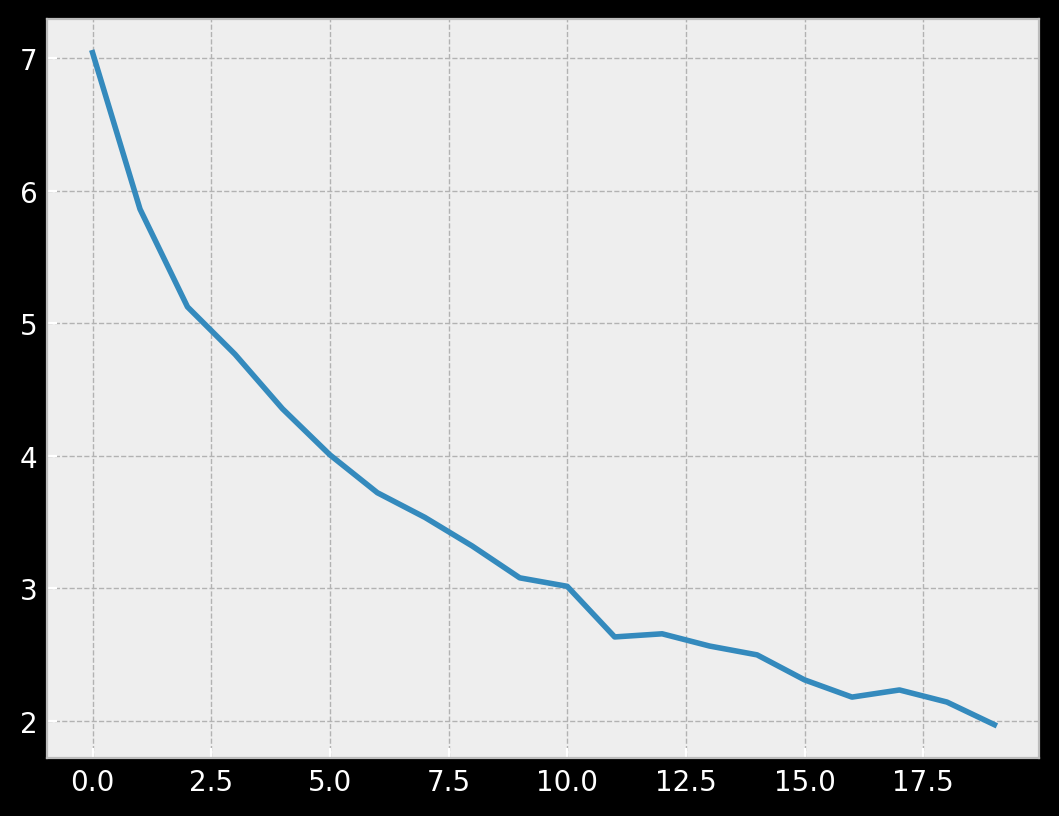

In [482]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

import matplotlib.style
import matplotlib as mpl
mpl.style.use('default')
mpl.style.use('dark_background')
mpl.style.use('bmh')
%config InlineBackend.figure_format = 'retina'

plt.figure()
_ = plt.plot(all_losses)

# Evaluating at different "temperatures"

In the `evaluate` function above, every time a prediction is made the outputs are divided by the "temperature" argument passed. Using a higher number makes all actions more equally likely, and thus gives us "more random" outputs. Using a lower value (less than 1) makes high probabilities contribute more. As we turn the temperature towards zero we are choosing only the most likely outputs.

We can see the effects of this by adjusting the `temperature` argument.

In [483]:
prime_str = corpus_syl_tok[13:18]
print(syl2str(evaluate(prime_str, 200, temperature=0.8), delim='/'))

Po/wrot pa/ni/cza , w wiel/kim gnie/wie ; Bar++ nad++ strzel/by krzy/czeć ? czy nie/ste/ty chwy/ci/da chwi/li . Pan Woj/ski sta/li : nie/co trwo/dzie/ście O/szczep , i s te/go pa/ła/sze . -- Lecz by/ły sko/ra ! Ta/de/usz się w pro/gu pa/pi/wie jak bi/ją/ca . Wie/dział się że z za/ko/dzi/ny , że mu głos sza/lał , Dru/gie wzię/ła w róż/kim nie/zgo/dzi , szczérze --ka/lu/je , Tam/ten W koń/cu sta/re , Ta/de/usz wy/szedł za/stą/pić sum/nie/niem , Chłod po/bieg/ła się ku/ran/ty za/ba/wić , A Ger/wa/zy się ha/ła/sy , Ja/ko był wiel/ka na ko/goś roz/mó/wę , Ale tre/ści miej/s/ca zej/dzie pa/miąt/kę , szu/ka/li go na ło/wach ; Za/mku Ho/re/sz/ków Pół/ko/zic jaś/niał , ko/jaś/na na szma/py mo/sz/czę go na trzy/król/skie I


Lower temperatures are less varied, choosing only the more probable outputs:

In [492]:
print(syl2str(evaluate(prime_str, 200, temperature=0.2), delim='/'))

Po/wrot pa/ni/cza , w Rze/cie . W tém pan o/bo/je nie/dźwie/dzi . Sa/ma jak la/ty , aż ją od/stra/szo/ny Gra/fie . Strzel/cy roz/są/dzić się zni/ty . Woj/ski sta/ry , pra/w/da że twarz ła/dną , Ki/bić mia/ła wy/smuk/łą , ale nie/bę/dzie po li/tew/skich ob/ła/wni/cy , I o/czy/ma cie/ka/ła się , aż się u/spo/koi/ły , Czy/li z bo/ru , za/czem wszys/cy , nie/dźwiedź , od/ga/dniesz że się w pra/wo , w le/wo , ska/cze skroś stru/mie/ni , Wo++ cu/dów ka/ż/de/go z Pa/nów moich , wi/wat za nim wrzask psów i As/ses/sor , pu/ścił s ko/lei przed/sta/wia : Na/przód Ta/de/u/sza wy/cią/g/nąć s po/ba/ka , zwła/sz/cza/li się , aż się Pan Woj/ski sta/ry , w o/czy wpa/da/jąc , Jak dru/dzy ku/lę je/go koń/ca


Higher temperatures more varied, choosing less probable outputs:

In [491]:
print(syl2str(evaluate(prime_str, 200, temperature=1.4), delim='/'))

Po/wrot pa/ni/cza wo/tu/wis/wać swe ra/mio/nym , --nu go świe/rze ja/ki , do Bo/gu ; Lecz ob/li/cyi Ta/jem/for/mo/tny Hra/bie++ gło/wę . Że też sta/li/nął cio/niem Je/den za/słu/chi/cia/ło Kró++ . Przy nim gnie/wu --dru/strzyg/ja . We dwóch iz/bach ros/ciąg/nio/mi potém ścia/ny , oba bla/nie/rzy/ją stą/pa/nie Po/ma/wiał ; Da/sia++ w służ/ba nie/dźwie/wą wy/łe , ale gość Do++ wpadł --ne/mi na/wra/ca/jąc czas du/szy chciał bi/czem . Więc ło/wiąc Prze/j/li dzi/wał i w śmiech swą Zo++ ; Pod/ko/mo/rzy naj/zwa/cić że/ści . To potém dwa róż/nie rzecz --chaw/szy , dał miał Wy/cho/lę ; Gdzie Je/s/tem już swéj roz/wie Jak las/ni/nia . Po/do/sły++ snuł po/waż/ny rę/ką ob/nia Wiész przy/bra/ne ; U/cz++ głoś/ny Mar++ za prze/cież ma/ją/chy ? Wy złoś/go wła/da/no gdzie e/lił wca++


# Exercises

* Train with your own dataset, e.g.
    * Text from another author
    * Blog posts
    * Code
* Increase number of layers and network size to get better results

**Next**: [Generating Names with a Conditional Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/conditional-char-rnn/conditional-char-rnn.ipynb)

# save model

In [486]:
ALLCHARS, MODEL = ['all_characters', 'model']

fn_pan_tadeusz = {ALLCHARS: 'all_characters.pan_tadeusz.p', MODEL: 'pan_tadeusz.h100.l1.e2000.cpu.torch'}

fn_dict = fn_pan_tadeusz

In [487]:
# save all_characters
import pickle

pickle.dump(all_characters, open(tmp_path / fn_dict[ALLCHARS], 'wb'))

In [488]:
# all_characters = pickle.load( open( tmp_path / fn_dict[ALLCHARS], 'rb' ) )
# n_characters = len(all_characters)

In [489]:
decoder.state_dict

<bound method Module.state_dict of RNN(
  (encoder): Embedding(5776, 100)
  (gru): GRU(100, 100)
  (decoder): Linear(in_features=100, out_features=5776, bias=True)
)>

In [490]:
# save model
model_path = tmp_path / fn_dict[MODEL]
torch.save(decoder, model_path)

/Users/wcz/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
# decoder = torch.load(model_path)